<a href="https://colab.research.google.com/github/Saswato/InterpretML-Model-Interpretability-in-Rice-Classification/blob/main/Model_Interpretability_Saswato_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 > > # **Model Interpretability of Linear, Tree Based and Auto ML models**







In [ ]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import shap


from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
shap.initjs()

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
from sklearn.linear_model import RidgeClassifier

## Importing Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving riceClassification.csv to riceClassification (2).csv


In [ ]:
import io
df = pd.read_csv(io.StringIO(uploaded['riceClassification.csv'].decode('utf-8')))

In [ ]:
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
df.columns

Index(['id', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation', 'Class'],
      dtype='object')

In [ ]:
df.drop('id',axis =1, inplace=True)

In [ ]:
X = df[['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation']]
y = df[['Class']]

## Test Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

#  1. Fit a linear model and interpret the regression coefficients

## **Logistic Regression**

In [ ]:
clf = RidgeClassifier().fit(X_train, y_train.values.ravel())


In [ ]:
def evaluate(X, y,reg):
  a=reg
  y_pred = a.predict(X)
  return mean_absolute_error(y, y_pred)


In [ ]:
y_pred_reg = clf.predict(X_test)

### Checking Test and Train MAE

In [ ]:
train_mae = evaluate(X_train, y_train,clf)
test_mae = evaluate(X_test, y_test,clf)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

train MAE = 0.003, test MAE = 0.169 


### Finding the regression coefficients

In [ ]:
coeff= clf.coef_
columns = X_test.columns

coeff

array([[ 1.72465829e-03,  1.42239619e-01, -9.29740620e-02,
        -2.08522011e+00, -1.05268818e-03, -2.82964820e-01,
         5.93579758e-02, -3.09050395e-03, -3.88794905e+00,
        -4.02342972e+00]])

In [ ]:
clf.classes_

array([0, 1])

In [ ]:
Linear_coefficients = pd.Series(coeff[0],columns)

The following graph visualizes the coefficient values of the predictors for class 0

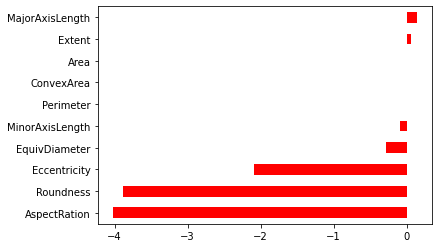

In [ ]:
%matplotlib inline
Linear_coefficients.sort_values().plot.barh(color='red');

### It can be observed that there is a negative correlation between most predictors and target class 0.
AspectRation and roundness are the major predictors

# 2. Fit a tree-based model and interpret the nodes

## **Decision Tree**

In [ ]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
clf_tree = DecisionTreeClassifier()
model = clf_tree.fit(X_train, y_train)



In [ ]:
train_mae = evaluate(X_train, y_train,clf_tree)
test_mae = evaluate(X_test, y_test, reg=clf_tree)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

train MAE = 0.0, test MAE = 0.876 


In [ ]:
Cols = [x for x in X_test.columns]
classes = [str(i) for i in clf_tree.classes_]

Cols, classes

(['Area',
  'MajorAxisLength',
  'MinorAxisLength',
  'Eccentricity',
  'ConvexArea',
  'EquivDiameter',
  'Extent',
  'Perimeter',
  'Roundness',
  'AspectRation'],
 ['0', '1'])

## Visualizing the nodes of Desicion Tree

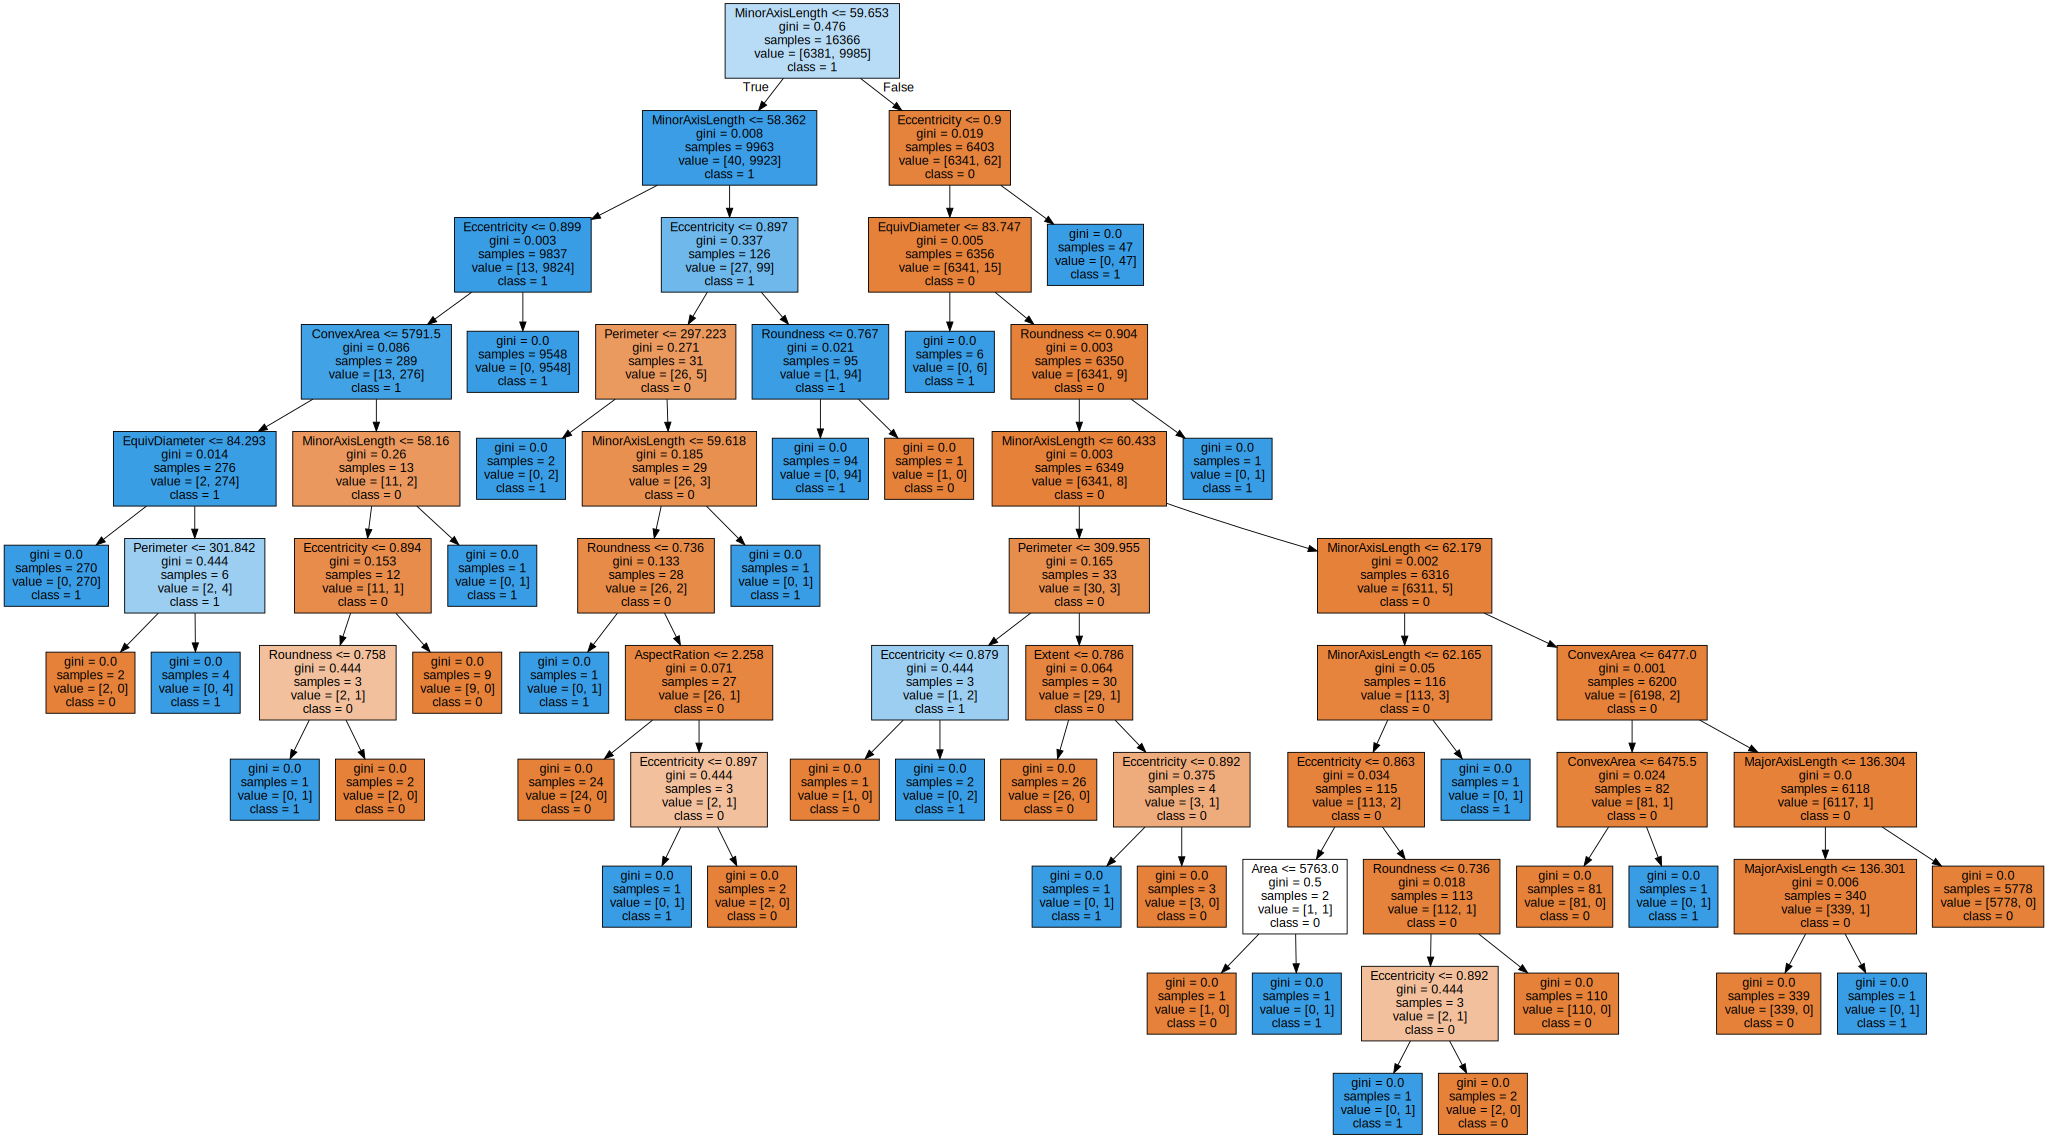

<Figure size 1800x1440 with 0 Axes>

In [ ]:
import graphviz
fig = plt.figure(figsize=(25,20))
dot_data = tree.export_graphviz(clf_tree,feature_names=Cols, class_names=classes,filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

### The above graph visualizes the node values at each level for the fitted decision tree.
Minor Axis Length and Eccentricity are the major predictors.

# 3.  Use auto ml to find the best model

## **Auto ML**

**Reference** [Decision tree classifier with sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [ ]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

#!pip uninstall h2o


!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [ ]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import seaborn as sns


### Set a minimum memory size and a run time in seconds

In [ ]:
min_mem_size=6 
run_time=222

### Use 50% of availible resources

In [ ]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


In [ ]:
port_no=random.randint(5555,55555)

In [ ]:
#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:37703 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14.1" 2022-02-08; OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpqrh0roc7
  JVM stdout: /tmp/tmpqrh0roc7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpqrh0roc7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:37703
Connecting to H2O server at http://127.0.0.1:37703 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_sskxcw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Reading Data in H2o frame

In [ ]:
df1 = h2o.H2OFrame(df)

df1.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
4537,92.2293,64.0128,0.719916,4677,76.0045,0.657536,273.085,0.76451,1.4408,1
2872,74.6919,51.4005,0.725553,3015,60.471,0.713009,208.317,0.831658,1.45314,1
3048,76.2932,52.0435,0.731211,3132,62.2963,0.759153,210.012,0.868434,1.46595,1
3073,77.0336,51.9285,0.738639,3157,62.5513,0.783529,210.657,0.870203,1.48346,1
3693,85.1248,56.374,0.749282,3802,68.5717,0.769375,230.332,0.874743,1.51,1
2990,77.4171,50.9543,0.752861,3080,61.7008,0.584898,216.93,0.798439,1.51934,1
3556,84.3236,55.4131,0.753762,3636,67.2877,0.750211,227.007,0.867148,1.52173,1
3788,86.9524,56.4448,0.760664,3866,69.448,0.800676,235.476,0.858473,1.54049,1
2629,74.1331,48.0741,0.761228,2790,57.8563,0.640595,207.325,0.768594,1.54206,1
5719,106.721,68.9777,0.763053,5819,85.3326,0.754983,281.839,0.904748,1.54718,1


In [ ]:
#Setting predictor and Target variables
X1= df1.columns
y1= 'Class'
X1.remove(y1)
X1

['Area',
 'MajorAxisLength',
 'MinorAxisLength',
 'Eccentricity',
 'ConvexArea',
 'EquivDiameter',
 'Extent',
 'Perimeter',
 'Roundness',
 'AspectRation']

###Test train split

In [ ]:
# Create a 80/20 train/test split
pct_rows=0.80
df_train, df_test = df1.split_frame([pct_rows])

### Train Auto ML

In [ ]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

aml.train(x=X1,y=y1,training_frame=df_train)

AutoML progress: |
03:47:21.927: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

███████
03:47:44.29: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

█
03:47:49.26: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categorical before training.

██████████
03:48:25.38: _response param, Response is numeric, so the regression model will be trained. However, the cardinality is equaled to two, so if you want to train a classification model, convert the response column to categoric

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.018755,0.001146,0.018894,0.017782,0.017498,0.019293,0.020310
1,mean_residual_deviance,0.008438,0.000575,0.008436,0.008155,0.007917,0.009409,0.008271
2,mse,0.008438,0.000575,0.008436,0.008155,0.007917,0.009409,0.008271
3,null_deviance,720.625600,14.041438,724.620100,721.227200,739.118000,718.132000,700.030900
4,r2,0.965897,0.002386,0.965742,0.966948,0.968110,0.961903,0.966783
5,residual_deviance,24.550583,1.675008,24.802100,23.828646,23.561022,27.353394,23.207758
6,rmse,0.091815,0.003082,0.091848,0.090305,0.088978,0.097003,0.090944
7,rmsle,0.064298,0.002439,0.064711,0.062290,0.062463,0.068288,0.063739


In [ ]:
print(aml.leaderboard)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20220425_34721,0.091848,0.00843605,0.0187379,0.0643292,0.00843605
StackedEnsemble_BestOfFamily_4_AutoML_1_20220425_34721,0.0919649,0.00845755,0.0189128,0.0644075,0.00845755
GBM_grid_1_AutoML_1_20220425_34721_model_2,0.0920832,0.00847932,0.018506,0.0643853,0.00847932
StackedEnsemble_BestOfFamily_3_AutoML_1_20220425_34721,0.0930289,0.00865438,0.0200044,0.065056,0.00865438
StackedEnsemble_AllModels_2_AutoML_1_20220425_34721,0.0930511,0.00865851,0.0199755,0.0651134,0.00865851
StackedEnsemble_AllModels_1_AutoML_1_20220425_34721,0.0931177,0.00867091,0.0200208,0.0650918,0.00867091
StackedEnsemble_BestOfFamily_2_AutoML_1_20220425_34721,0.0931955,0.0086854,0.0205223,0.0651203,0.0086854
GBM_grid_1_AutoML_1_20220425_34721_model_3,0.093684,0.0087767,0.0206295,0.0655891,0.0087767
StackedEnsemble_BestOfFamily_1_AutoML_1_20220425_34721,0.0937786,0.00879442,0.0217533,0.0655205,0.00879442
GBM_1_AutoML_1_20220425_34721,0.094045,0.00884445,0.0213121,0.0656796,0.00884445


In [ ]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict

{'GBM_grid_1_AutoML_1_20220425_34721_model_2': 2,
 'GLM_1_AutoML_1_20220425_34721': 26,
 'StackedEnsemble_AllModels_3_AutoML_1_20220425_34721': 0,
 'StackedEnsemble_BestOfFamily_4_AutoML_1_20220425_34721': 1}

### Best Auto ML model

In [ ]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

2


In [ ]:
best_model.algo

'gbm'

### Thus we find that GBM is the best model for the Rice Classification dataset.

# 4. Run SHAP analysis on the models from steps 1, 2, and 3,   interpret the SHAP values

## **Model Interprestability using SHAP values**

### SHAP values for Linear Regression(Ridge classifier)

In [ ]:
explainer = shap.LinearExplainer(clf, X_train, feature_names=X_train.columns)

shap_values = explainer.shap_values(X_test)

In [ ]:
x = X_train.sample(frac=0.01,random_state=200) # Using 1% of data because shap cannot handle thousands of entries
explainer = shap.LinearExplainer(clf, x, feature_perturbation="interventional") # Using linear explainer to explain logistic model
shap_values = explainer.shap_values(x) #Storing shap values

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

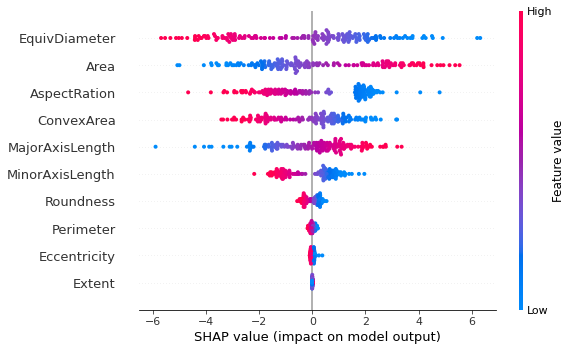

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, x)

### Thus from the above plots it is evident that in the Linear Model, EquivDiameter and Area were the major predictors.

### SHAP values for Decision tree

In [ ]:
shap.initjs()
 # Define a tree explainer for the built model
explainer = shap.TreeExplainer(clf_tree)
 # obtain shap values for the first row of the test data
shap_values = explainer.shap_values(X_test.iloc[0])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0]) 

In [ ]:
choosen_instance = X_train.loc[[1]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

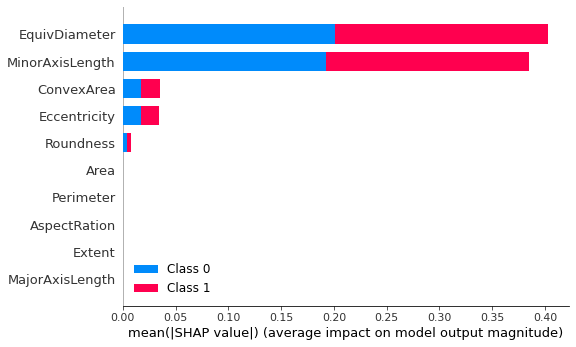

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=X_train.columns)

### The summary plot for Decion tree gives us the feature importance along with the effects. 
EquivDiameter and MinorAxisLength were the main predictors.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

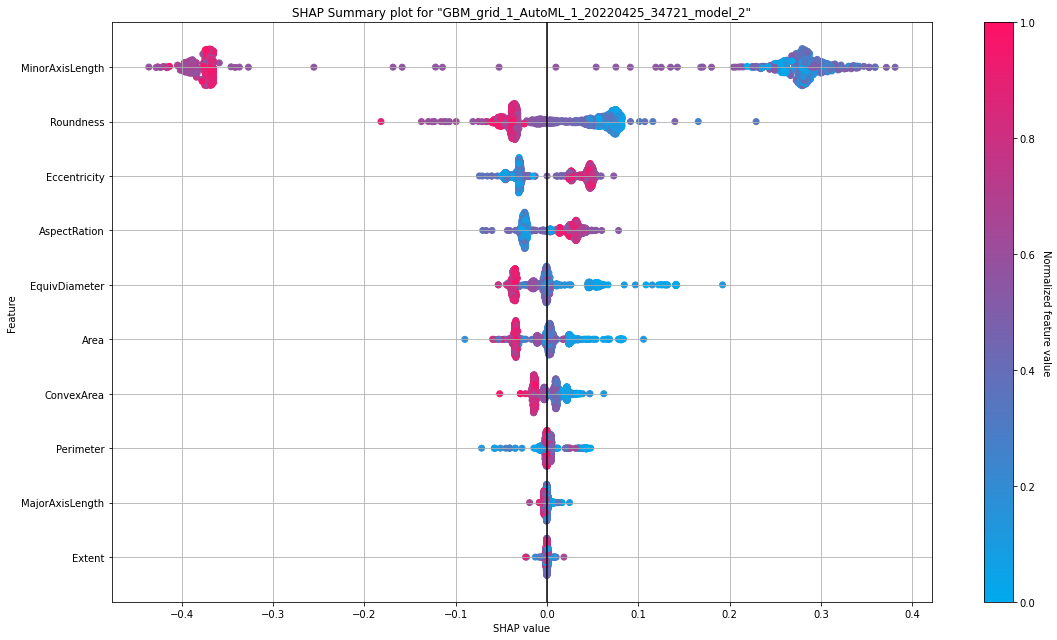

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

In [ ]:
aml.explain(df_test, include_explanations="shap_summary")

### Above visual shows that MinorAxisLength and Roundness were the top predictors.

# 4. Run PDP analysis on the models from steps 1, 2, and 3

## **Model Interpretability using PDP plots**

### PDP for Linear Model

In [ ]:
from sklearn.inspection import plot_partial_dependence


Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


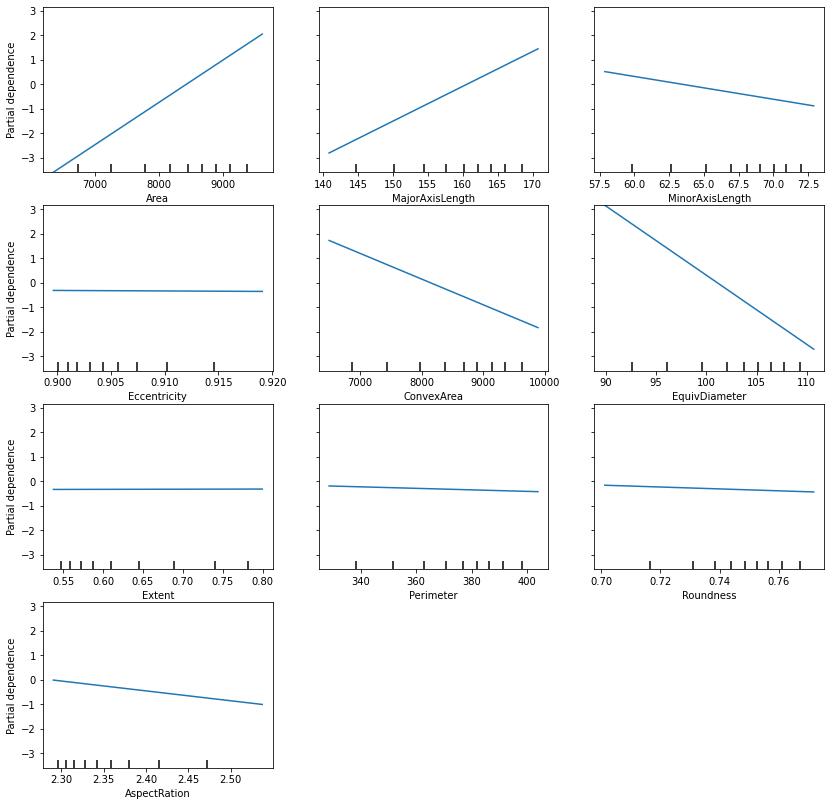

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
plot_partial_dependence(clf, X_test, Cols, ax=ax )


**Reference:** [PDP](https://towardsdatascience.com/how-to-interpret-models-pdp-and-ice-eabed0062e2c)

### PDP on Decision Tree

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


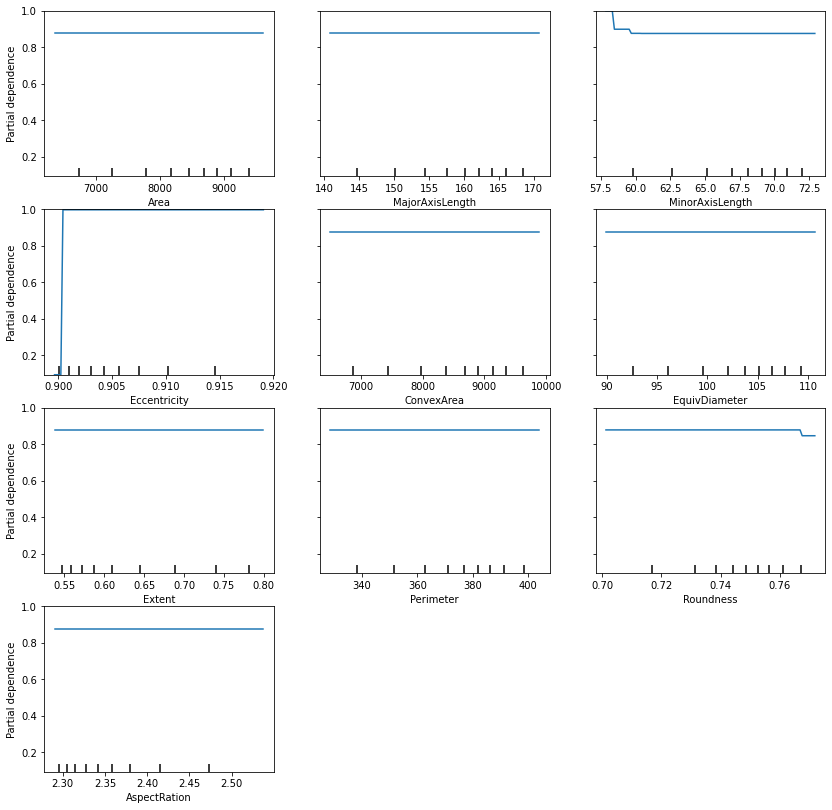

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
plot_partial_dependence(clf_tree, X_test, Cols, ax=ax)

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

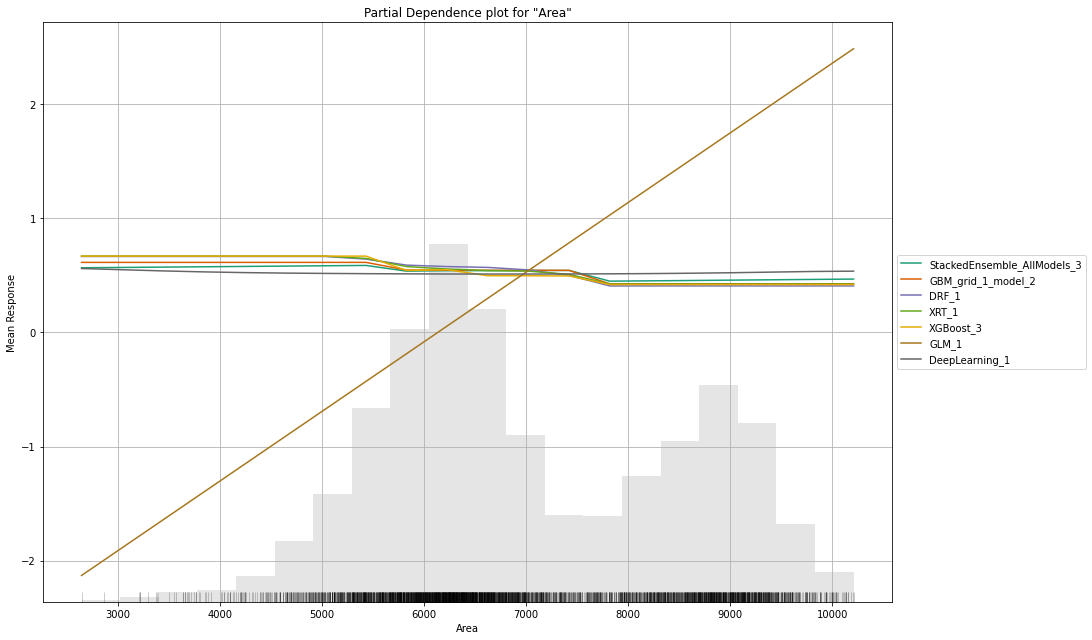

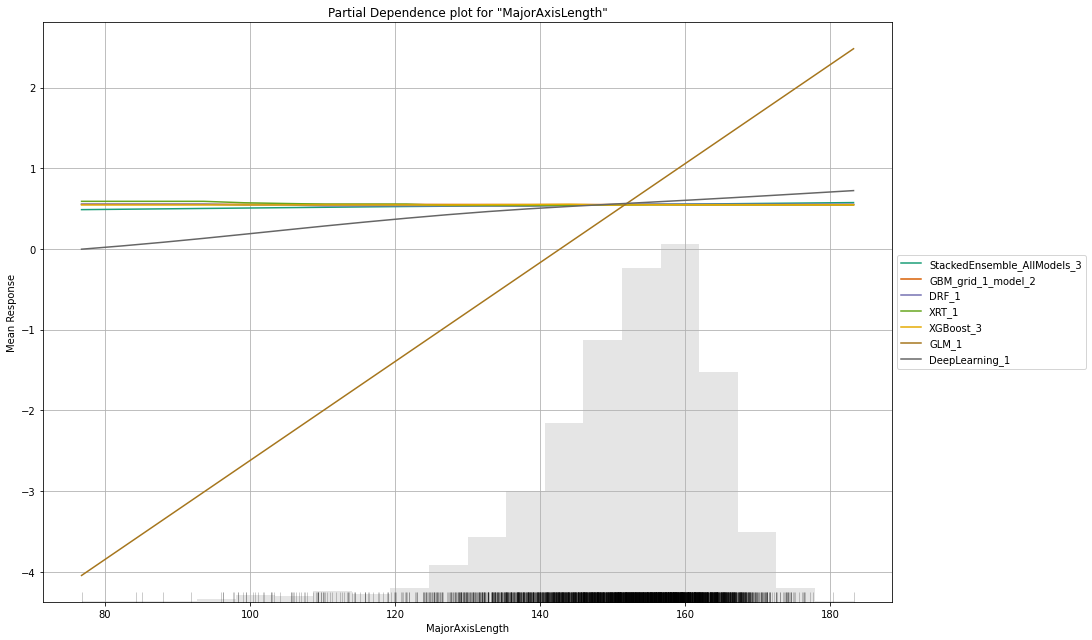

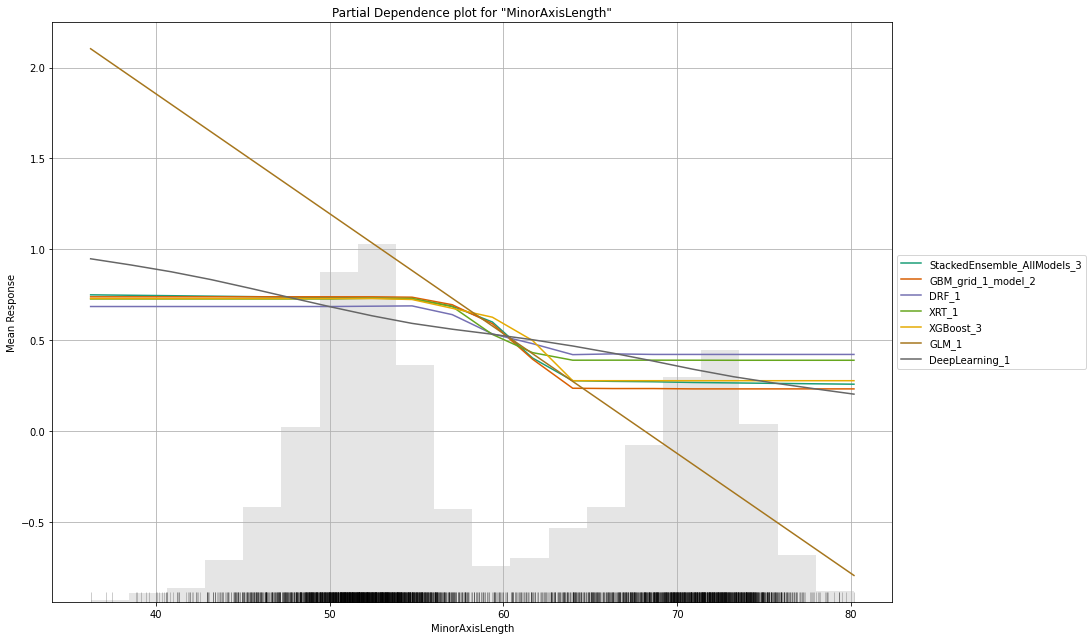

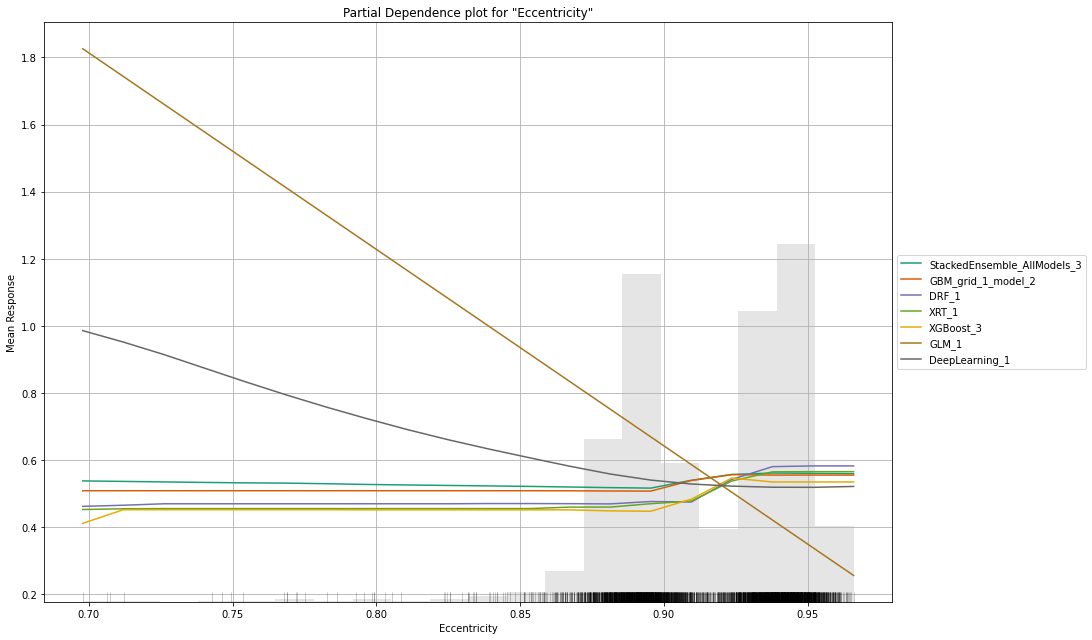

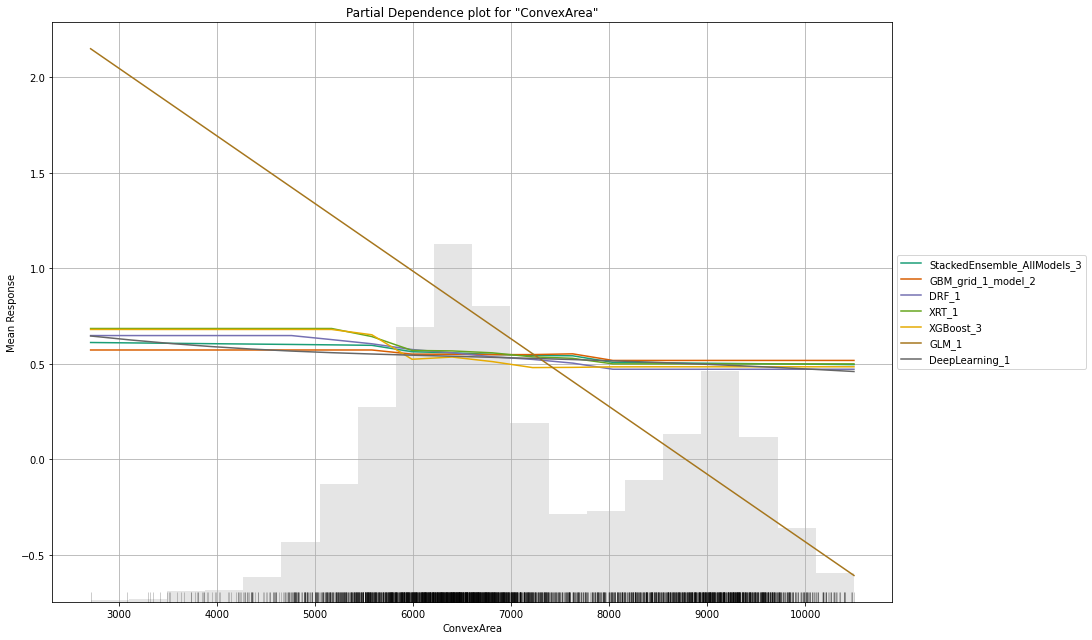

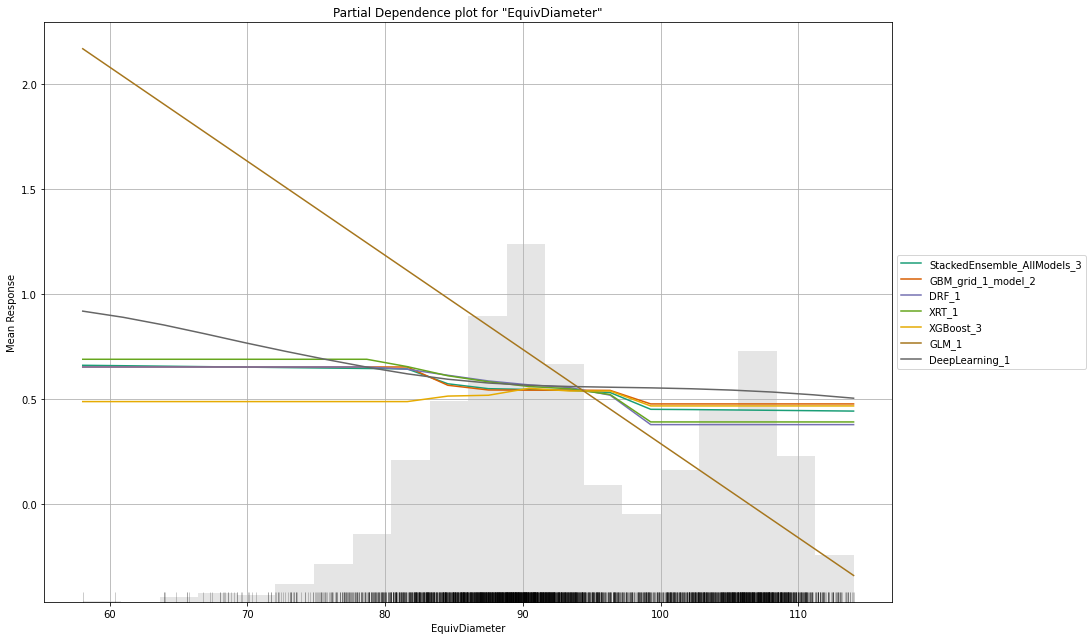

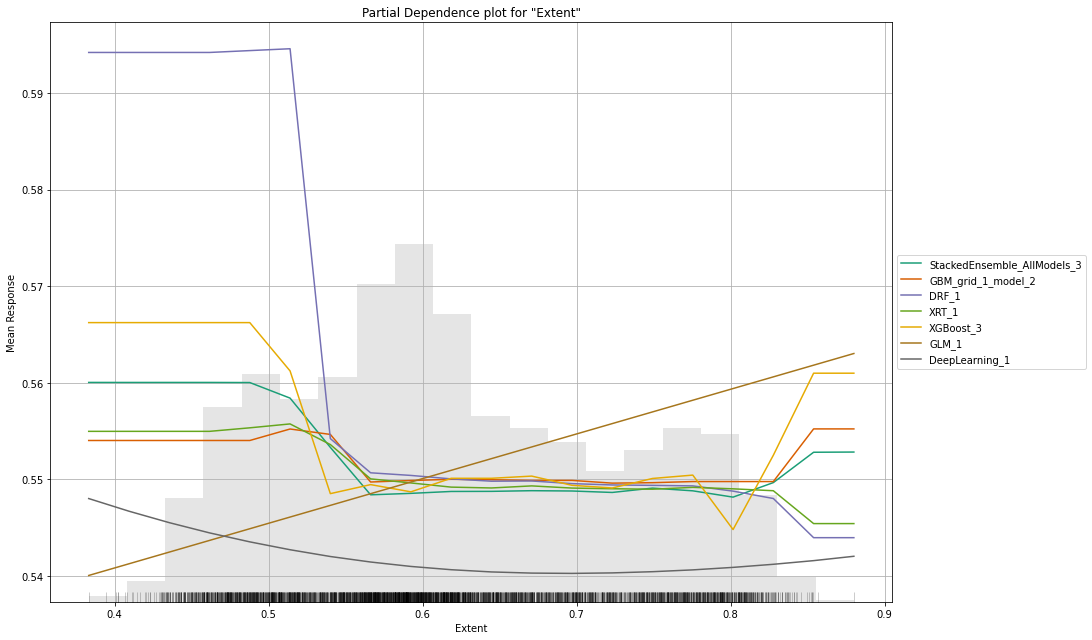

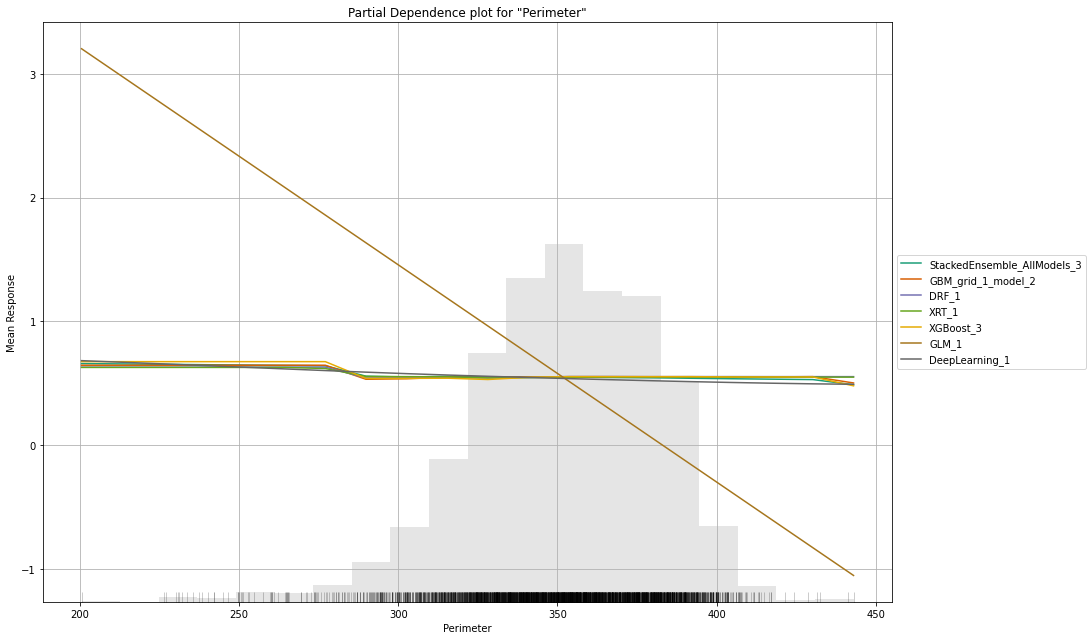

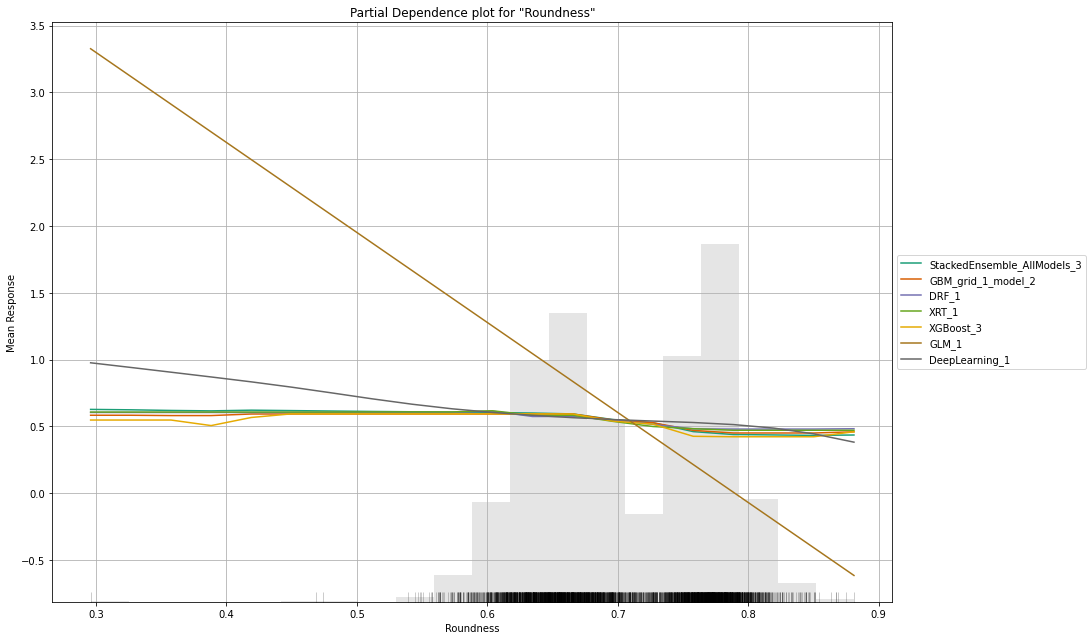

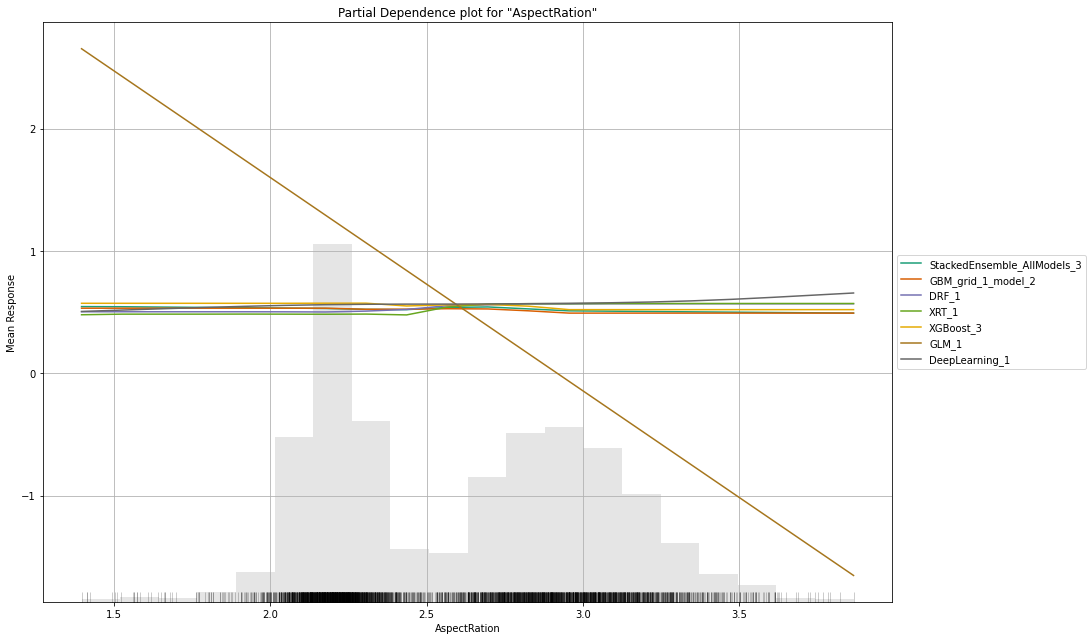

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [ ]:
aml.explain(df_test, include_explanations="pdp")

### In Conclusion, SHAP values explain feature importance clearly for most models while it is not so evident through PDP plots for complex models.

MIT License

Copyright (c) 2022 Saswato Bhattacharyya

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.